In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import skimage
import skimage.io
import scipy.io as sio
import skimage.transform
import sys
import tensorflow as tf
import numpy as np
import sys
import os
import scipy.io as sio
import re
import time
from tqdm import tqdm
np.random.seed(0)

In [2]:
outputChannels = 16
# savePrefix = ""
# outputPrefix = ""
# 0=car, 1=person, 2=rider, 3=motorcycle, 4=bicycle, 5=truck, 6=bus, 7=train
train = False
batchSize = 2
learningRate = 5e-6 # usually i use 5e-6
wd = 1e-6


In [3]:
from io_utils import *

In [4]:
from skimage import io, morphology
import skimage
import itertools

from scipy import ndimage as ndi

In [5]:
feeder = Batch_Feeder(dataset_path="../../watershednet/data/for_training/42/", 
                      unet_output_path = '../../pytorch-nested-unet/outputs/42',
                       subset='test',
                       batchSize=batchSize,
                       padWidth=None,
                       padHeight=None, 
                       flip=False,
                       keepEmpty=False,
                       train=True,
                       img_shape = (384,384))
feeder.set_paths()

scanning ../../watershednet/data/for_training/42/test


In [6]:
from network_init import get_model

In [7]:
model = get_model(modelWeightPaths=["../final_model/model_010.mat"])

In [8]:
import math
import matplotlib.pyplot as plt


attempting to build model
building direction net

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
loaded direction/conv1_1/weights


loaded direction/conv1_1/biases
loaded direction/conv1_2/weights
loaded direction/conv1_2/biases

loaded direction/conv2_1/weights
loaded direction/conv2_1/biases
loaded direction/conv2_2/weights
loaded direction/conv2_2/biases
loaded direction/conv3_1/weights
loaded direction/conv3_1/biases
loaded direction/conv3_2/weights
loaded direction/conv3_2/biases
loaded direction/conv3_3/weights
loaded direction/conv3_3/biases

loaded direction/conv4_1/weights
loaded direction/conv4_1/biases
loaded direction/conv4_2/weights
loaded direction/conv4_2/biases
loaded direction/conv4_3/weights
loaded direction/conv4_3/biases
loaded direction/conv5_1/weights
loaded direction/conv5_1/biases
loaded direction/conv5_2/weights
loaded direction/conv5_2/biases
loaded direction/conv5_3/weights
loaded directio

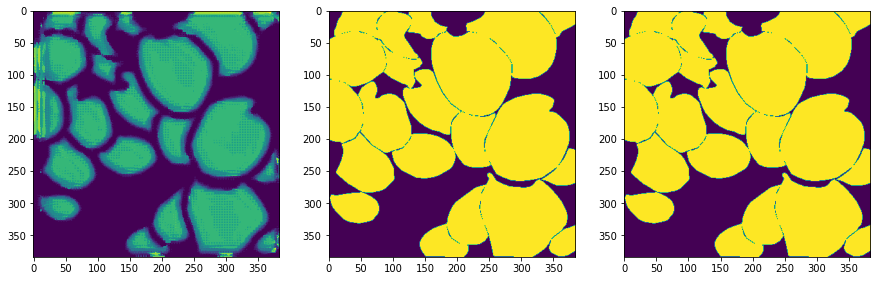

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2


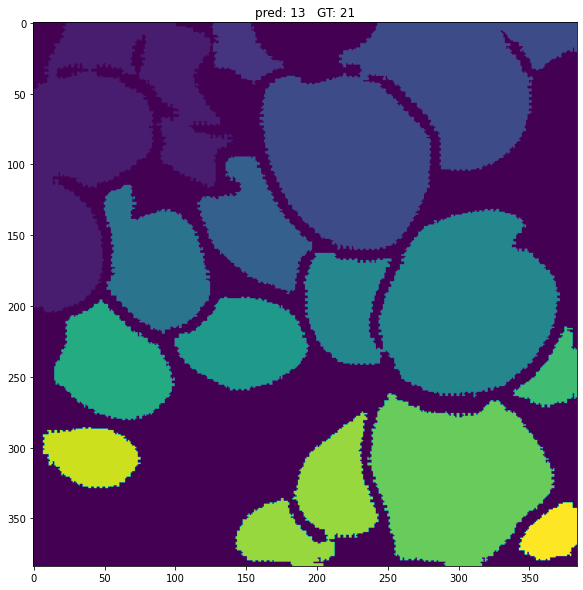

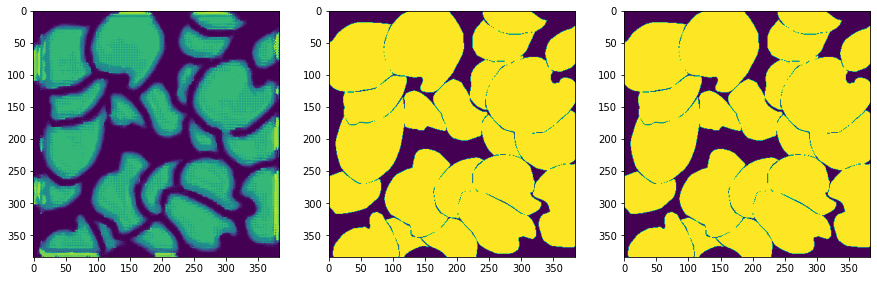

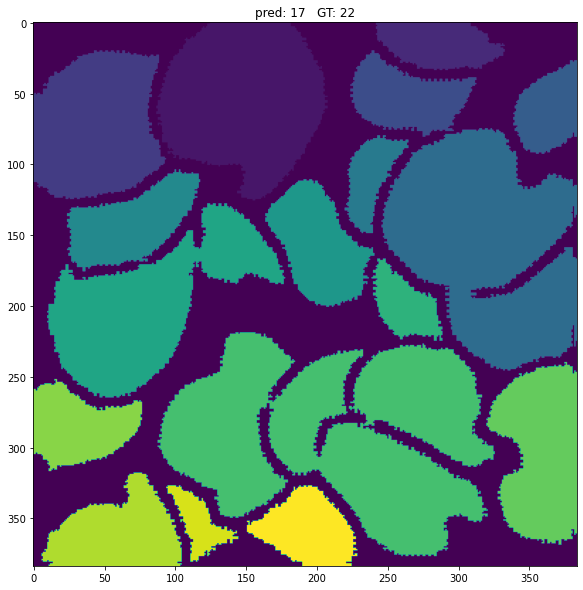

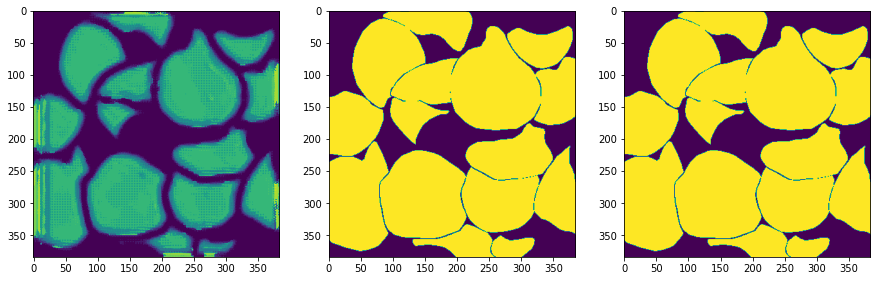

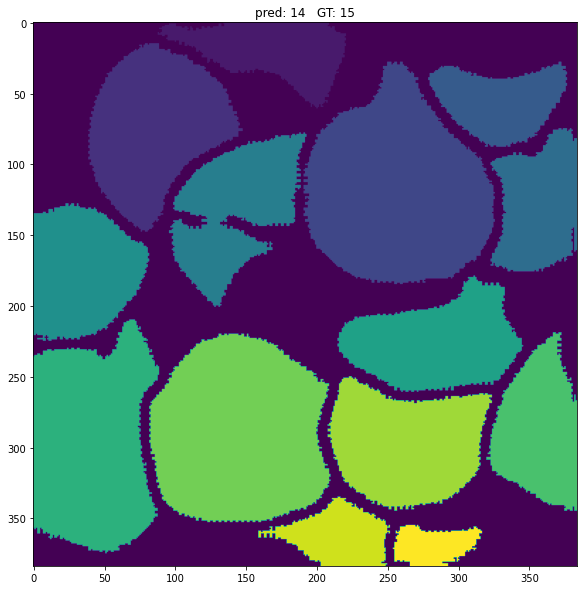

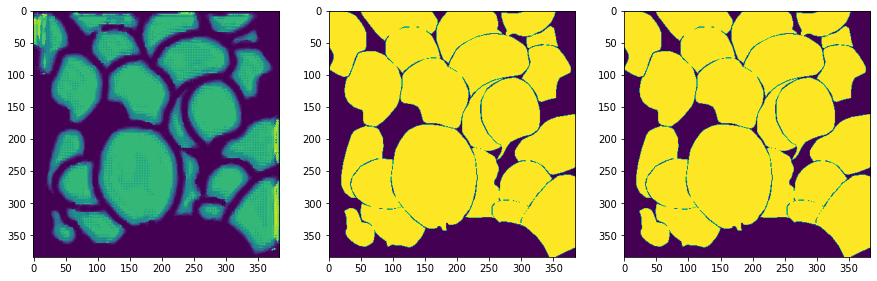

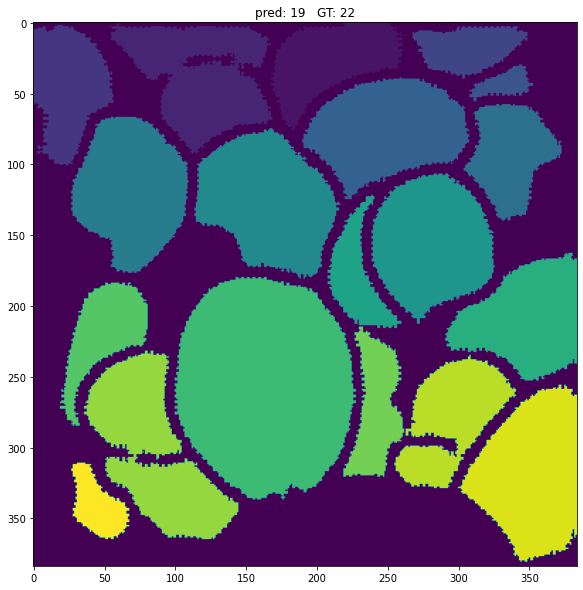

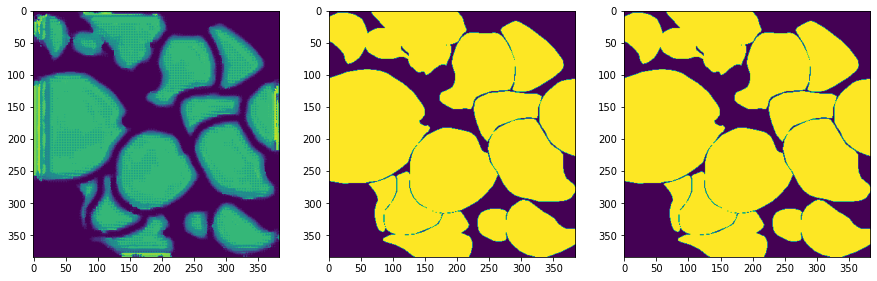

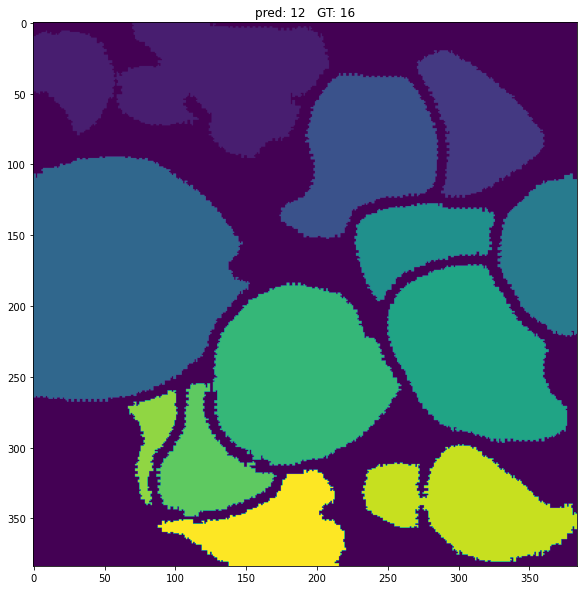

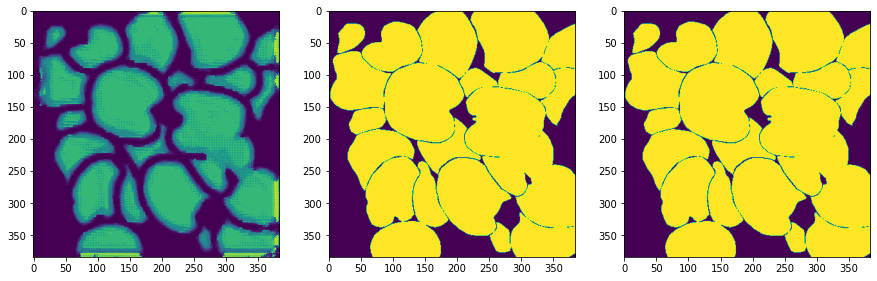

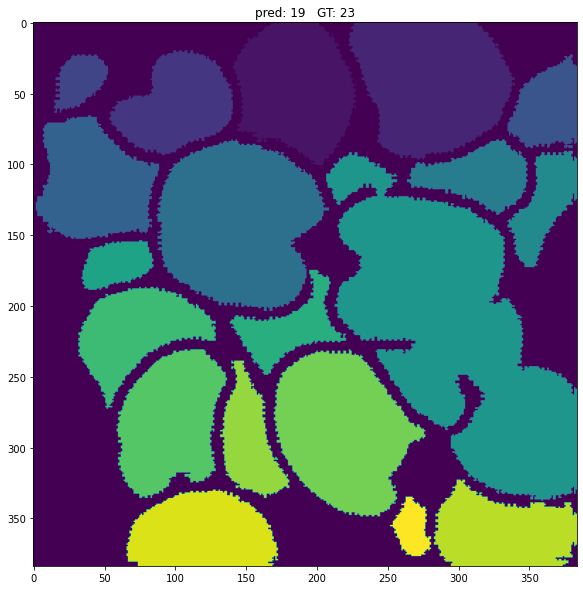

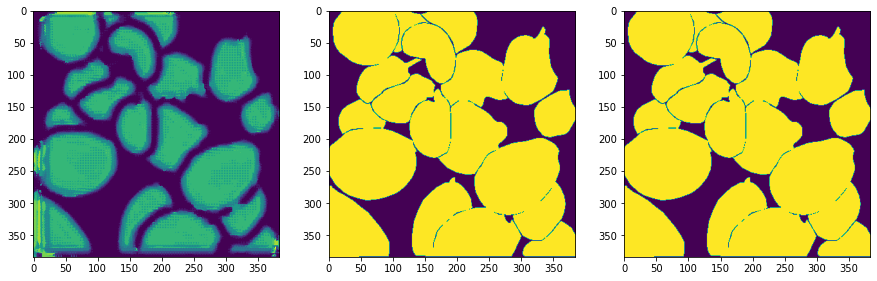

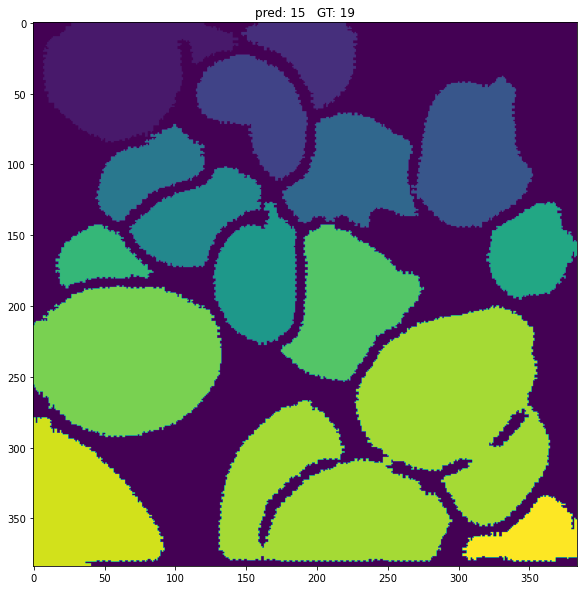

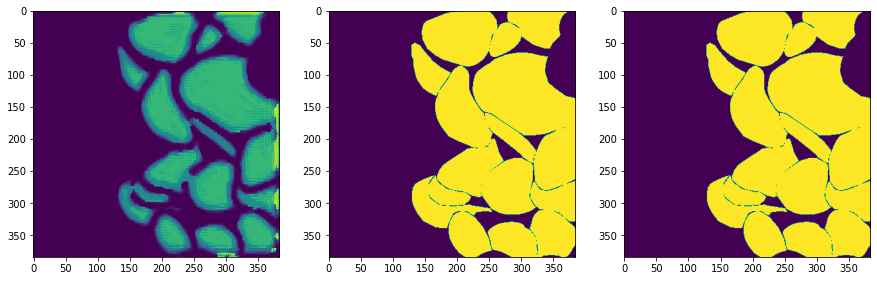

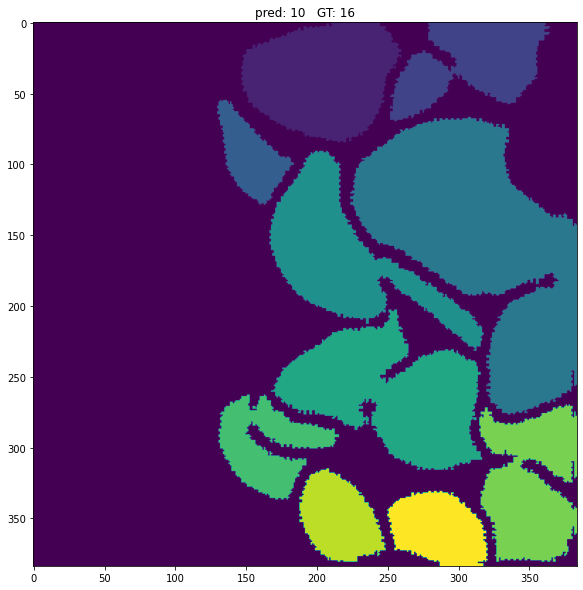

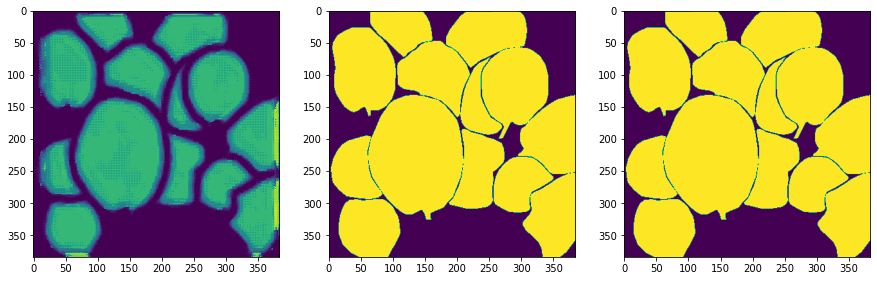

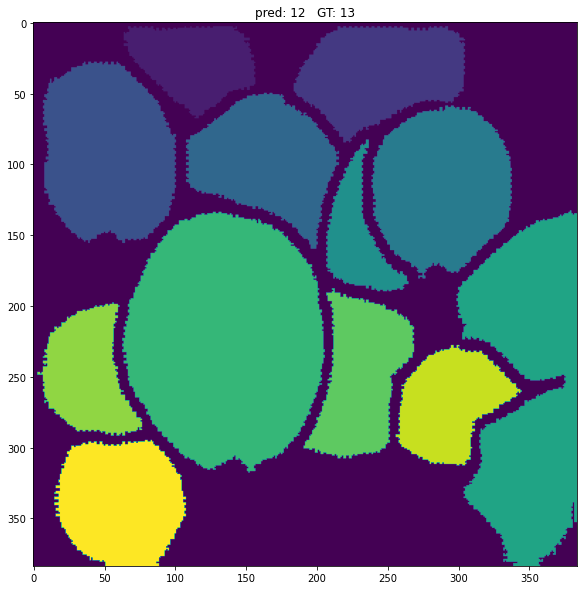

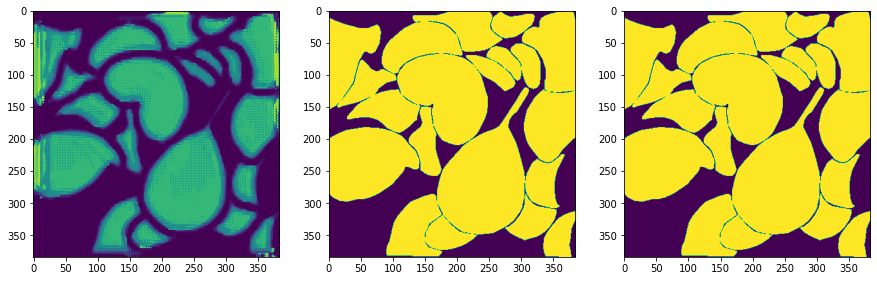

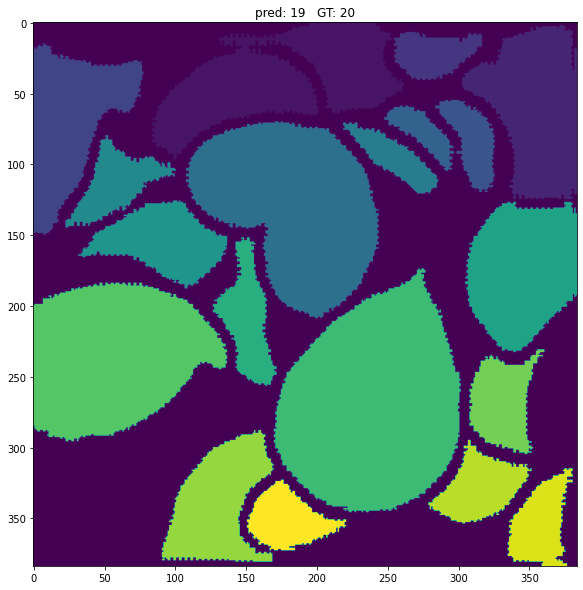

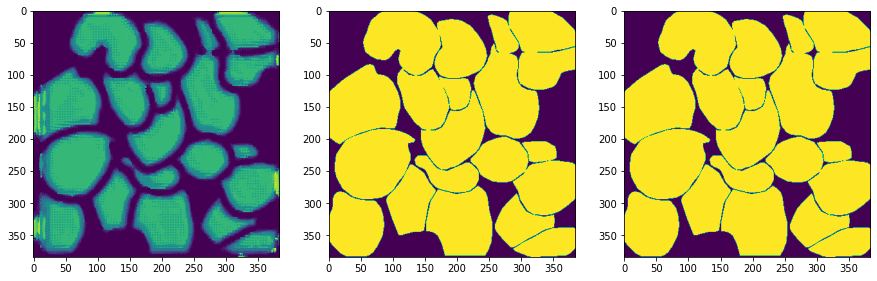

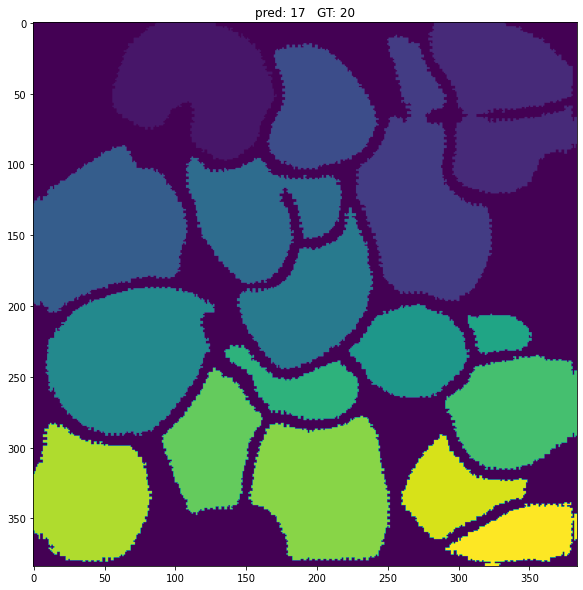

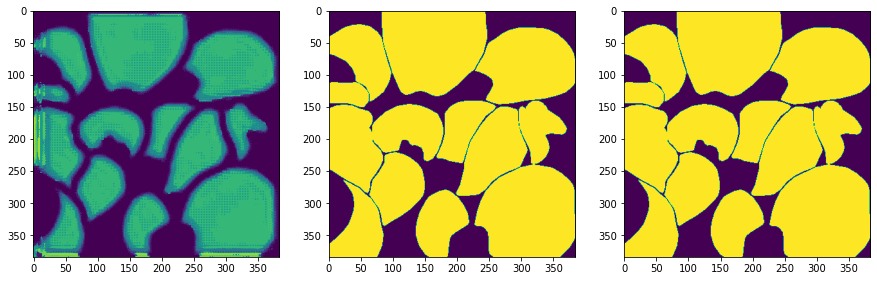

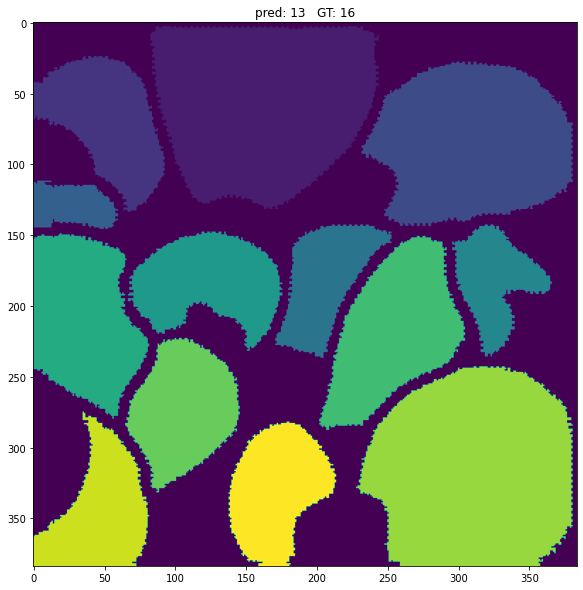

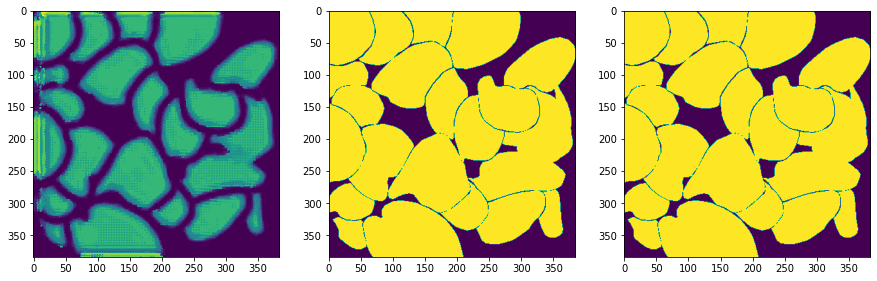

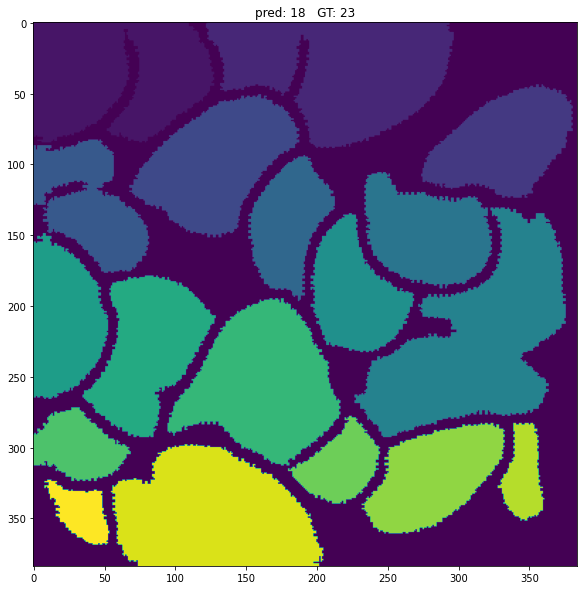

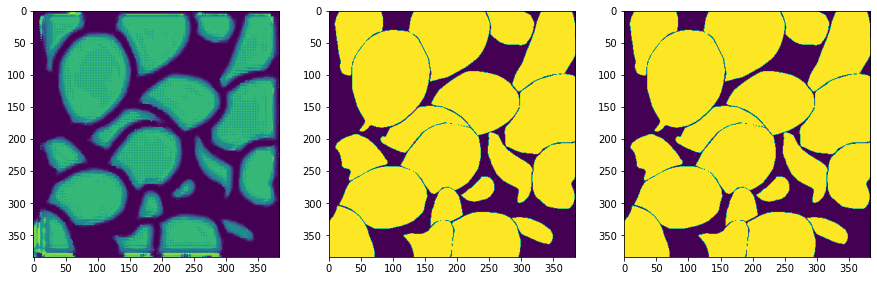

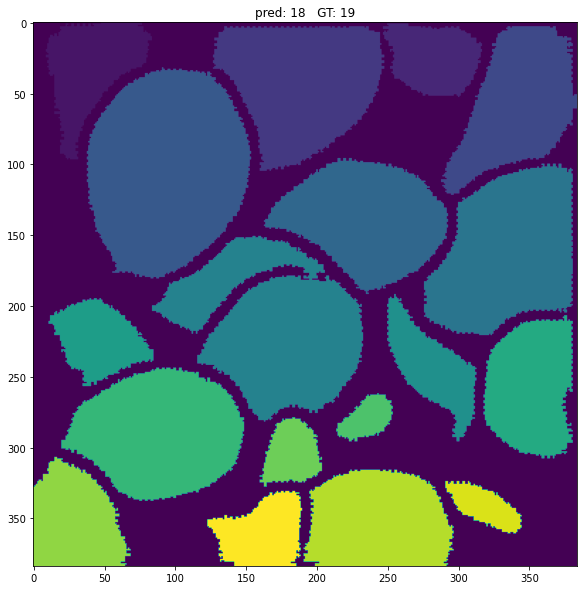

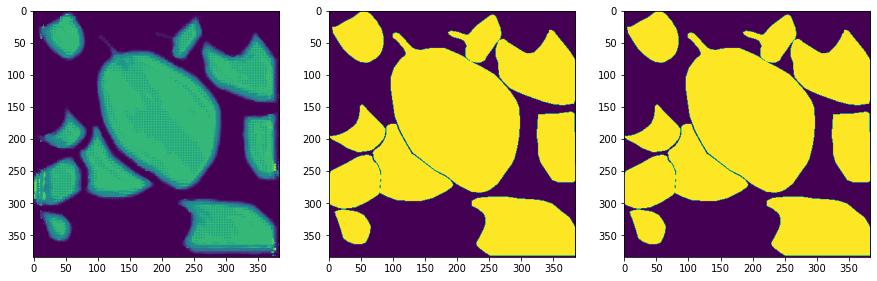

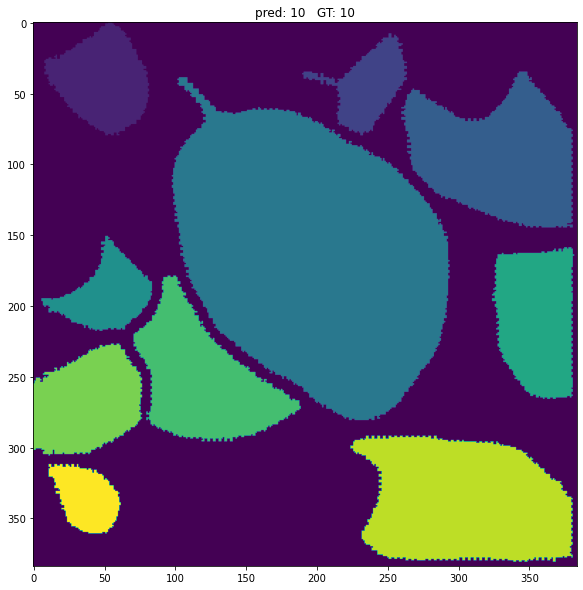

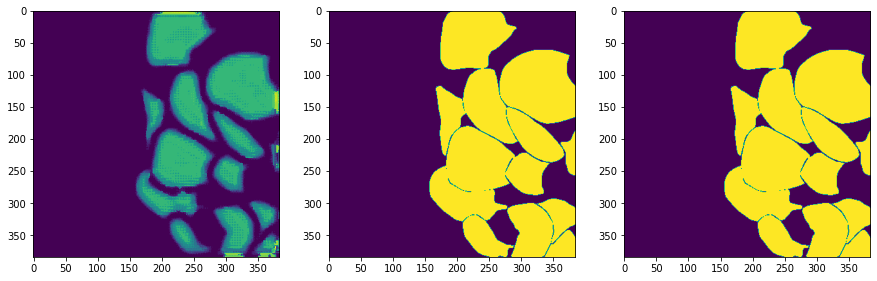

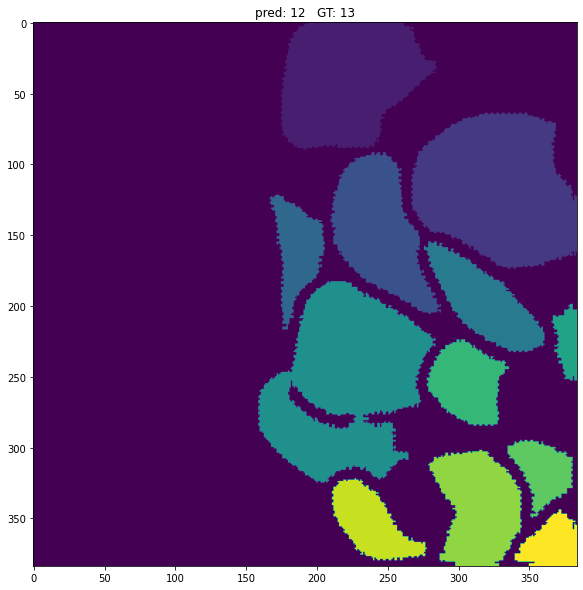

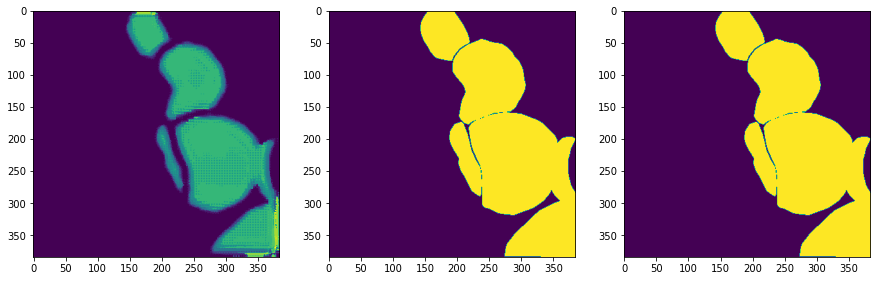

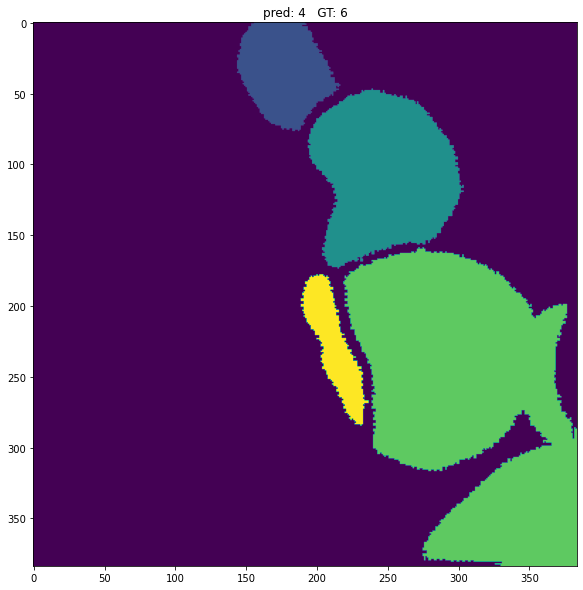

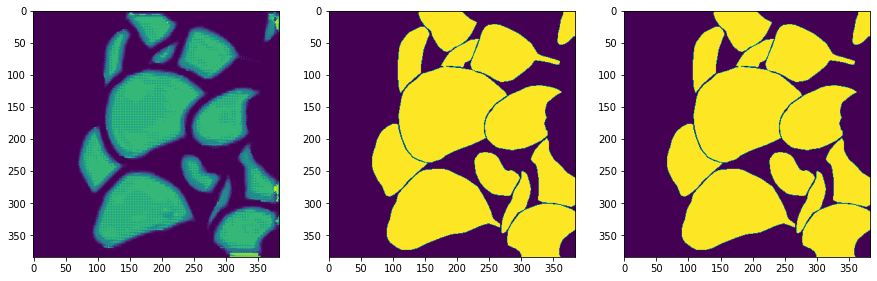

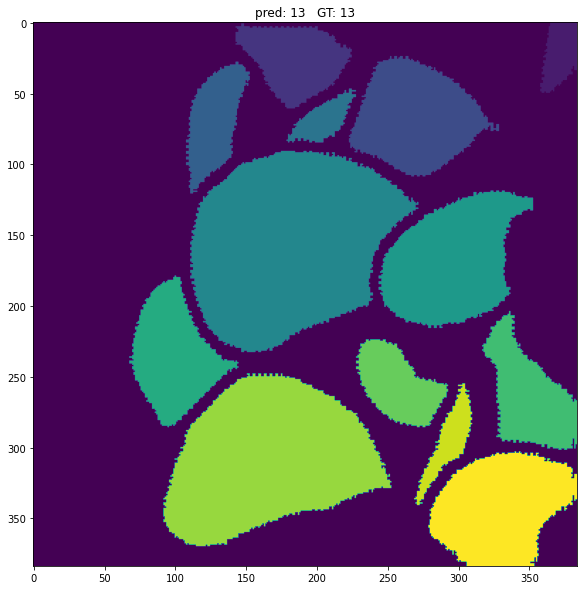

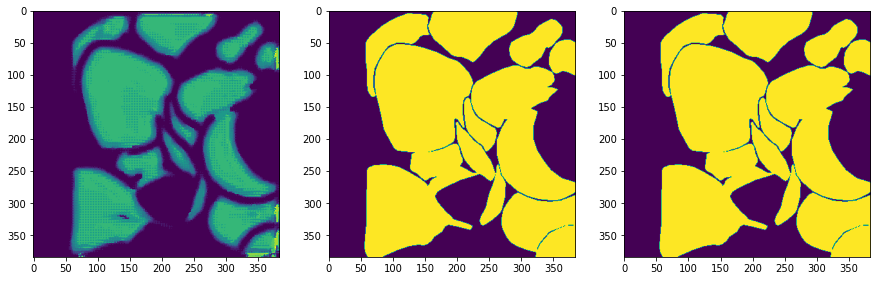

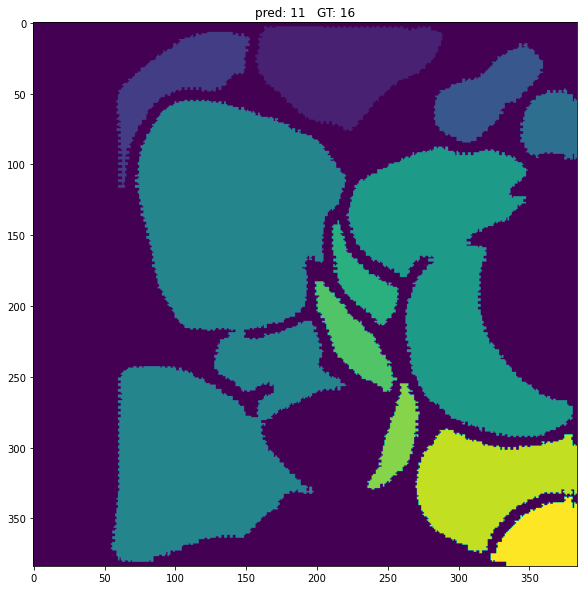

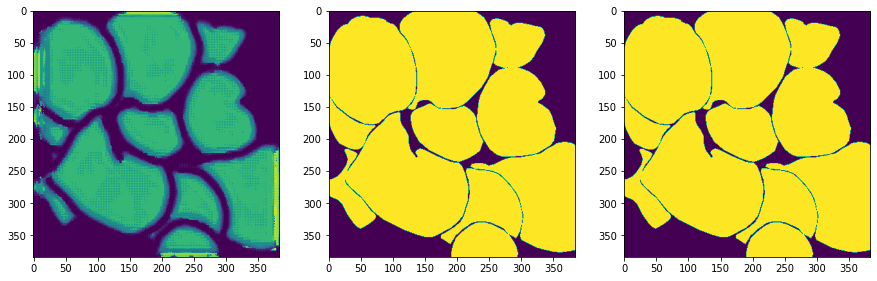

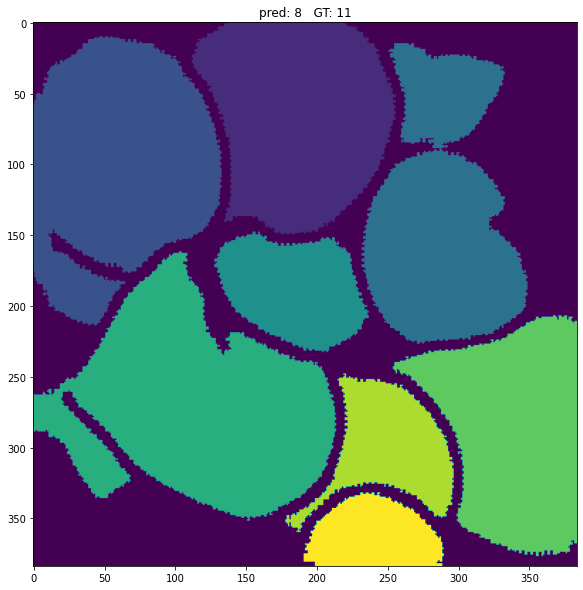

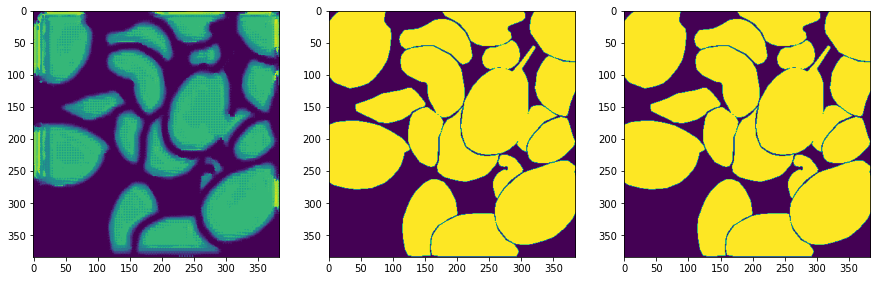

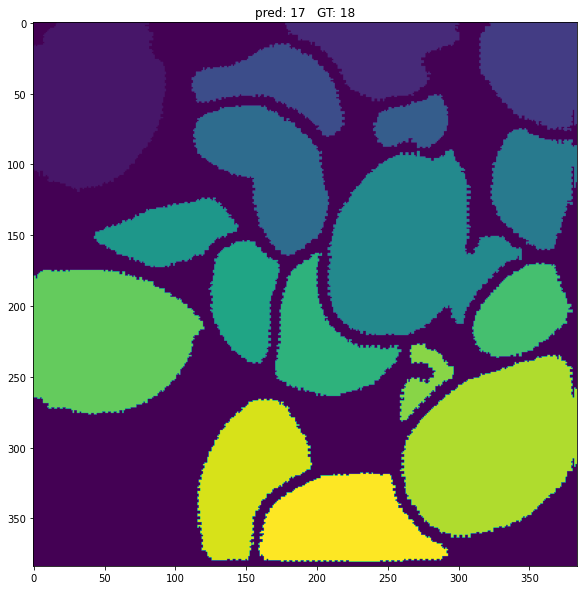

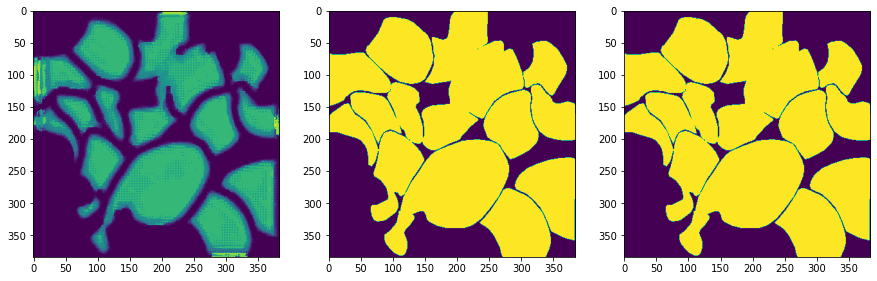

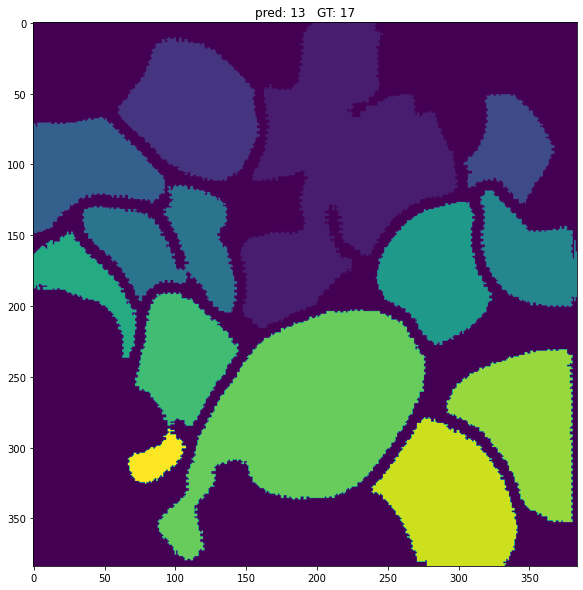

In [9]:
with tf.Session() as sess:
    tfBatchImages = tf.placeholder("float", shape=[None, 384, 384, 3])
    tfBatchGT = tf.placeholder("float", shape=[None, 384, 384])
    tfBatchSS = tf.placeholder("float", shape=[None, 384, 384])
    keepProb = tf.placeholder("float")

    with tf.name_scope("model_builder"):
        print ("attempting to build model")
        model.build(tfBatchImages, tfBatchSS, keepProb=keepProb)
        print ("built the model")
    sys.stdout.flush()

    init = tf.initialize_all_variables()
    print ("attempting to run init")
    sys.stdout.flush()

    sess.run(init)
    print ("completed init")
    sys.stdout.flush()

    for i in range(int(math.floor(feeder.total_samples() / batchSize))):
        imageBatch, gtBatch, ssBatch, n_polygons = feeder.next_batch()

        outputBatch = sess.run(model.outputDataArgMax, feed_dict={tfBatchImages: imageBatch,
                                                                  tfBatchGT: gtBatch,
                                                                  tfBatchSS: ssBatch,
                                                                  keepProb: 1.0})
        #outputBatch = outputBatch.astype(np.uint8)
        #print(outputBatch.shape)
        
        plt.figure(figsize=(15,15))
        plt.subplot(131)
        plt.imshow(outputBatch[0])
        plt.subplot(132)
        plt.imshow(ssBatch[0])
        plt.subplot(133)
        plt.imshow(ssBatch[0])
        plt.show()
        
        depth = outputBatch[0]
        ss = ssBatch[0]

        ccImage = (depth>0.5)*ss
        ccImage = ccImage.astype(np.bool)
        ccImage = skimage.morphology.remove_small_objects(ccImage, min_size=500)
        ccImage = skimage.morphology.remove_small_holes(ccImage)
        labeled_image, labels = skimage.morphology.label(ccImage, neighbors=8,background=0, return_num=True)
        #print("[*] detected {} intial regions".format(labels))
        plt.figure(figsize=(10,10))
        plt.imshow(labeled_image)
        plt.title("pred: {}   GT: {}".format(labels, n_polygons))
        plt.show()


In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(outputBatch[0])
plt.subplot(132)
plt.imshow(ssBatch[0])
plt.subplot(133)
plt.imshow(ssBatch[0])

In [ ]:
#plt.imshow(outputBatch[0]>0.5)

In [ ]:
from skimage import io, morphology
import skimage
import itertools

from scipy import ndimage as ndi

ccImage = (depth>0.5)*ss
ccImage = ccImage.astype(np.bool)
ccImage = skimage.morphology.remove_small_objects(ccImage, min_size=500)
ccImage = skimage.morphology.remove_small_holes(ccImage)
labeled_image, labels = skimage.morphology.label(ccImage, neighbors=8,background=0, return_num=True)
print("[*] detected {} intial regions".format(labels))
plt.figure(figsize=(10,10))
plt.imshow(labeled_image)

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(labeled_image)

In [ ]:
# train_model(model=model, outputChannels=outputChannels,
#             learningRate=learningRate,
#             trainFeeder=trainFeeder, valFeeder=valFeeder,
#             modelSavePath="../models/direction", savePrefix=savePrefix,
#             initialIteration=initialIteration)

In [ ]:
!ls ../models/direction

In [ ]:
modelWeightPaths = ["../models/direction/direction_unified_CR_unified_CR_pretrain_150.mat"]

In [ ]:
from train_direction import initialize_model

In [ ]:
#modelWeightPaths = ["./cityscapes/models/direction/direction3_unified_ss_wide_pretrain_VGGFIX_020.mat"]

model = initialize_model(outputChannels=outputChannels, wd=0, modelWeightPaths=modelWeightPaths)

# feeder = Batch_Feeder(dataset="cityscapes", indices=indices, train=train, batchSize=batchSize, padWidth=None, padHeight=None)
# feeder.set_paths(idList=read_ids("./cityscapes/splits/vallist.txt"),
#                  imageDir="./cityscapes/inputImages/val",
#                  ssDir="./cityscapes/unified/ssMaskFineGT/val")



In [ ]:
import math
# batchSize = 8

In [ ]:
with tf.Session() as sess:
    tfBatchImages = tf.placeholder("float", shape=[None, 384, 384, 3])
    tfBatchGT = tf.placeholder("float", shape=[None, 384, 384, 2])
    tfBatchSS = tf.placeholder("float", shape=[None, 384, 384])

    with tf.name_scope("model_builder"):
        print ("attempting to build model")
        model.build(tfBatchImages, tfBatchSS)
        print ("built the model")
    sys.stdout.flush()

    init = tf.initialize_all_variables()
    sess.run(init)
    
    
    for i in tqdm(range(int(math.floor(valFeeder.total_samples() / batchSize)))):

        imageBatch, gtBatch, ssBatch = valFeeder.next_batch()

        outputBatch = sess.run(model.output, feed_dict={tfBatchImages: imageBatch,
                               tfBatchGT: gtBatch,
                               tfBatchSS: ssBatch})
        
        

#         for j in range(len(idBatch)):
#             outputFilePath = os.path.join(outputSavePath, idBatch[j]+'.mat')
#             outputFileDir = os.path.dirname(outputFilePath)

#             if not os.path.exists(outputFileDir):
#                 os.makedirs(outputFileDir)

#             sio.savemat(outputFilePath, {"dir_map": outputBatch[j]}, do_compression=True)

#             print ("processed image %d out of %d"%(j+batchSize*i, feeder.total_samples()))



In [ ]:
outputBatch.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
img = outputBatch[1]
gt = gtBatch[1]

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img[:,:,0])
plt.subplot(122)
plt.imshow(gt[:,:,0])

In [ ]:
def forward_model(model, feeder, outputSavePath):
    with tf.Session() as sess:
        tfBatchImages = tf.placeholder("float", shape=[None, 384, 384, 3])
        tfBatchGT = tf.placeholder("float", shape=[None, 384, 384, 2])
        tfBatchSS = tf.placeholder("float", shape=[None, 384, 384])

        with tf.name_scope("model_builder"):
            print ("attempting to build model")
            model.build(tfBatchImages, tfBatchSS)
            print ("built the model")
        sys.stdout.flush()

        init = tf.initialize_all_variables()
        sess.run(init)

        for i in range(int(math.floor(feeder.total_samples() / batchSize))):
            imageBatch, ssBatch, ssMaskBatch, idBatch = feeder.next_batch()

            outputBatch = sess.run(model.output, feed_dict={tfBatchImages: imageBatch, tfBatchSS: ssBatch, tfBatchSSMask: ssMaskBatch})

            for j in range(len(idBatch)):
                outputFilePath = os.path.join(outputSavePath, idBatch[j]+'.mat')
                outputFileDir = os.path.dirname(outputFilePath)

                if not os.path.exists(outputFileDir):
                    os.makedirs(outputFileDir)

                sio.savemat(outputFilePath, {"dir_map": outputBatch[j]}, do_compression=True)

                print ("processed image %d out of %d"%(j+batchSize*i, feeder.total_samples()))


In [ ]:
forward_model(model, feeder=feeder,
              outputSavePath="./training/output/direction_ss")